In [4]:
import pandas as pd
import numpy as np
import os
import math
import random

os.makedirs('lscour_calcs', exist_ok=True)

# From Trampush et al., 2014
Trampush_velocities = {
    '50':1.2843137254901962,
    '25':0.8413867822318526,
    '75':1.6939077776156426
}

a0 = -2.08
a1 = 0.254
a2 = -1.09

D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50 (mm)

trampush_2014 = pd.read_csv('3rd_party/trampush_2014_utf8.csv')
trampush_WD = np.nanmean(trampush_2014['Wbf [m]']/trampush_2014['Hbf [m]']) # Average width to depth ratio

seconds_in_month = 2629800

R = 1.65 # Submerged specific gravity for quartz
g = 9.81 # gravity

rho = 1000 # density of water (kg/m^3)
ps =  2650 # density of sediment (kg/m^3)
t_crit = 0.03 # critical shields stress

def estimate_tc(row):
    # Lamb et al., 2008
    return np.power(0.15*row['S [-]'], 0.25)
    
Hbf_Dunne = lambda S, tc, rho, g: (1.2*tc)/(rho*g*S)

def Hbf_K_and_J(row): 
    return Hbf_Dunne(row['S [-]'], row['t_c_bank'], rho, g)

def Hbf_velocity(row):
    if row['discharge [cms]'] > 5:
        return row['discharge [cms]']/row['U [m/s]']/row['Width [m]']
    else:
        return row['Width [m]']/trampush_WD

def Hbf_Yamazaki(row):
    Hbf_est = 0.5*np.power(row['discharge [cms]'], 0.3)
    if Hbf_est < 1:
        Hbf_est = 1
    return Hbf_est

def Wbf_Yamazaki(row):
    Wbf_est = 15*np.power(row['discharge [cms]'], 0.5)
    if Wbf_est < 10:
        Wbf_est = 10
    return Wbf_est

def tb_depth_slope(row):
    return rho*g*row['Hbf [m]']*row['S [-]']

def get_D50(row):
    D50_regression = float(D50_trampush(row['Hbf [m]'], row['S [-]']))/float(1000)
#     D50_shields = (row['t_b']/(row['t_c']*(ps-rho)*g))

    if random.randrange(0, 2, 1):
        return D50_regression
    else:
        return D50_regression
    
def estimate_Cf(row):
    return (g*row['S [-]']*row['Hbf [m]'])/np.power(row['U [m/s]'], 2)

def L_b(row):
    return row['Hbf [m]']/row['S [-]']/1000

# Ma et al., 2017 D50

def n_Ma(D50):
    # Ma et al. [2017] n exponent
    return (1.322 / (1 + np.exp(math.pow(10,5) * ((-1 * D50) + (1.6 * math.pow(10, -4))  )))) + 1.678
      
def a_Ma(D50):
    # Ma et al. [2017] alpha exponent
    return (0.859 / (1 + np.exp(math.pow(10,5) * (D50 - (1.6 * math.pow(10, -4))  )))) + 0.036

def Qs_Ma(row):
    
    a_ma_rep = a_Ma(row['D50 [m]'])
    n_ma_rep = n_Ma(row['D50 [m]'])        
    
    tau_star = ((row['Hbf [m]'])*row['S [-]'])/(R*row['D50 [m]'])
    
    qs_star = (a_ma_rep*np.power(tau_star, n_ma_rep))/row['Cf']
    qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m]'],3))
    
    return qs*row['Width [m]']

def t_adj(row):
    
    m2_per_s = float(row['Qs [cms]'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['L_b [km]'])*1000 # m
    hbf = float(row['Hbf [m]'])*row['flood_multiple'] # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    # Return months
    return t_adj_s/seconds_in_month

def l_scour_GRL(row):
    
    a_ma_rep = a_Ma(row['D50 [m]'])
    n_ma_rep = n_Ma(row['D50 [m]']) 

    lscour_top = np.sqrt(R*g*(np.power(row['D50 [m]'],3)))*a_ma_rep*np.power((row['Hbf [m]']*row['flood_multiple'])*row['S [-]'], n_ma_rep)
    lscour_bottom = row['Hbf [m]']*(row['L_b [km]']*1000)*row['Cf']*np.power(R*row['D50 [m]'],n_ma_rep)
    lscour_Lb = np.power((row['Tscour [months]'])* seconds_in_month * (lscour_top/lscour_bottom), 0.5)
    lscour_rep = lscour_Lb*(row['L_b [km]']*1000)

    return lscour_rep/1000
    
def l_scour_Tadj(row):
    
    return (row['L_b [km]']*1000)*np.sqrt((row['Tscour [months]']*seconds_in_month/(row['T_adj [months]']*seconds_in_month)))/1000


In [8]:
# Monte Carlo Simulations

global_avulsions = pd.read_csv(os.path.join('data', 'global_avulsion_db_width_est.csv'))
global_avulsions = global_avulsions.loc[global_avulsions['Wbf'] > 0]
num_reps = 200

df_all = pd.DataFrame()

for rid, row in global_avulsions.iterrows():

    # Uniform distribution of slope within IQR
    
    print(row['Av_ID'])
    
    S = []
    
    if row['Upstream S_IQR [-]'] > 0:
        
        lower_bound = row['Upstream S [-]']-(row['Upstream S_IQR [-]']*0.5)
        upper_bound = row['Upstream S [-]']+(row['Upstream S_IQR [-]']*0.5)
        
        while len(S)<num_reps:
            slope = random.uniform(lower_bound, upper_bound)
            if slope > 0:
                S.append(slope)
    else:
        
        S = [row['Upstream S [-]']]*num_reps
    
    # Uniform distribution of widths using standard deviation
        
    if row['Width_std [m]'] > 0:
        widths = np.random.normal(row['Width [m]'], row['Width_std [m]'], num_reps)
    else:
        widths = [row['Width [m]']]*num_reps

    df = pd.DataFrame({'S [-]': S, 'Width [m]': widths})
    
    df['Av_ID'] = row['Av_ID']
    df['River'] = row['River']
    df['L_A [km]'] = row['L_A [km]']
    df['L_A_error [km]'] = row['L_A_error [km]']
#     df['t_c'] = df.apply(estimate_tc, axis=1)
    df['t_c'] = t_crit
  
    t_c_bank = []
    
    for _ in range(num_reps): t_c_bank.append(random.randrange(6, 11, 1))
    
    df['t_c_bank'] = t_c_bank    
    
    flood_multiple = []
    for _ in range(num_reps): flood_multiple.append(random.randrange(2, 5, 1)) # Floods are between 2 and 4 time bankfull
    # e.g. (Gibling 2006; Ganti et al. 2014a; Trower et al. 2018; Ganti et al., 2019)

    df['flood_multiple'] = flood_multiple
    
    # Flow velocity
    
    U = []
    for _ in range(num_reps): U.append(random.uniform(Trampush_velocities['25'], Trampush_velocities['75']))
    df['U [m/s]'] = U
    
    df['discharge [cms]'] = row['discharge [cms]']

    # Channel depths (Either Velocity or K&J)

    if (row['From'] != 'madagascar'):
        df['Hbf (recorded) [m]'] = row['Hbf [m] (recorded)']
    else:
        df['Hbf (recorded) [m]'] = 0
        
    if row['Hbf [m] (recorded)'] > 0:  
        df['Hbf [m]'] = row['Hbf [m] (recorded)']
    else:
        df['Hbf [m]'] = df.apply(Hbf_Yamazaki, axis=1)
    
    
#     df['Hbf (velocity) [m]'] = df.apply(Hbf_velocity, axis=1)
#     df['Hbf (K&J) [m]'] = df.apply(Hbf_K_and_J, axis=1)
    
    
    df['L_b [km]'] = df.apply(L_b, axis=1)
    
    df['t_b'] = df.apply(tb_depth_slope, axis=1)
    
    if row['D50 [m] (recorded)'] > 0:
        df['D50 [m]'] = row['D50 [m] (recorded)']
        df['GRL'] = 1
    else:
        df['D50 [m]'] = df.apply(get_D50, axis=1)
        df['GRL'] = 0
    
    if row['Cf'] > 0:
        df['Cf'] = row['Cf']
    else:
        df['Cf'] = df.apply(estimate_Cf, axis=1)
    
    # Sediment flux
    if row['D50 [m] (recorded)'] > 0:
        df['Qs [cms]'] = df.apply(Qs_Ma, axis=1)
    else:
#         if row['WBMSed Qs [kgs]'] > 0:
#             df['Qs [cms]'] = row['WBMSed Qs [kgs]']/ps
#         else:
            df['Qs [cms]'] = df.apply(Qs_Ma, axis=1)
    
    # Tscour
    if row['Tscour [months]'] > 0:
        df['Tscour [months]'] = row['Tscour [months]']
    else:
        tscour_range = []
        for _ in range(num_reps): tscour_range.append(random.uniform(1.5, 2))
        df['Tscour [months]'] = tscour_range
        
    df['T_adj [months]'] = df.apply(t_adj, axis=1)
    
    if row['D50 [m] (recorded)'] > 0:
        df['l_scour [km]'] = df.apply(l_scour_GRL, axis=1)
    else:
        df['l_scour [km]'] = df.apply(l_scour_Tadj, axis=1)
    
    df.to_csv(os.path.join('lscour_calcs', row.Av_ID+'.csv'))
              
    df_all = df_all.append(df)
    

AFR0211_1998


ZeroDivisionError: float division by zero

In [3]:
def IQR(dat):
    return np.nanpercentile(dat, 75)-np.nanpercentile(dat, 25)

df_grouped = df_all.groupby("Av_ID").agg([np.nanmedian, IQR, np.mean, np.std])

# avocado_prices.plot(kind = "scatter", y = "mean", legend = False, title = "Test", xerr = "std")

df_grouped

KeyError: 'Av_ID'

        S [-]   Width [m]            Av_ID       River  L_A [km]  \
0    0.000255  138.244386     AFR0211_1998   Catumbela     2.049   
1    0.000314  192.127529     AFR0211_1998   Catumbela     2.049   
2    0.000408  158.916293     AFR0211_1998   Catumbela     2.049   
3    0.000388  145.242839     AFR0211_1998   Catumbela     2.049   
4    0.000386  154.787697     AFR0211_1998   Catumbela     2.049   
..        ...         ...              ...         ...       ...   
195  0.002344   38.050000  FIHERENANA_2001  Fiherenana     5.240   
196  0.002234   38.050000  FIHERENANA_2001  Fiherenana     5.240   
197  0.002092   38.050000  FIHERENANA_2001  Fiherenana     5.240   
198  0.002406   38.050000  FIHERENANA_2001  Fiherenana     5.240   
199  0.002272   38.050000  FIHERENANA_2001  Fiherenana     5.240   

     L_A_error [km]   t_c  t_c_bank  flood_multiple   U [m/s]  ...  \
0               0.0  0.03         7               3  1.231855  ...   
1               0.0  0.03         6        

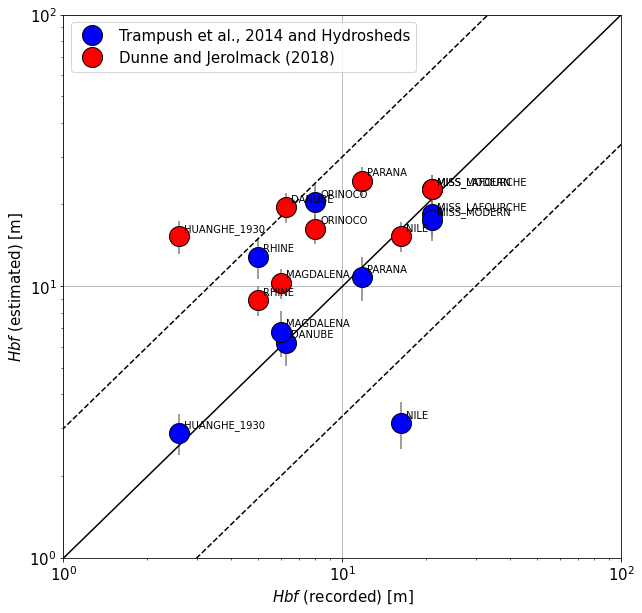

In [4]:
# Depth estimation vs. recorded

print(df_all)
df_all_depth_recorded = df_all.loc[df_all['Hbf (recorded) [m]'] > 0 ]
df_grouped_depth_recorded = df_all_depth_recorded.groupby("Av_ID").agg([np.nanmedian, IQR, np.mean, np.std])

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*3
refplot_lower = refplot/3

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped_depth_recorded['Hbf (recorded) [m]']['nanmedian'], 
            df_grouped_depth_recorded['Hbf (velocity) [m]']['nanmedian'], 
            xerr=df_grouped_depth_recorded['Hbf (recorded) [m]']['IQR']/2, 
            yerr=df_grouped_depth_recorded['Hbf (velocity) [m]']['IQR']/2, 
            fmt='o', ms=20, markerfacecolor='blue', ecolor='grey', 
            markeredgecolor='black', label='Trampush et al., 2014 and Hydrosheds')

ax.errorbar(df_grouped_depth_recorded['Hbf (recorded) [m]']['nanmedian'], 
            df_grouped_depth_recorded['Hbf (K&J) [m]']['nanmedian'], 
            xerr=df_grouped_depth_recorded['Hbf (recorded) [m]']['IQR']/2, 
            yerr=df_grouped_depth_recorded['Hbf (K&J) [m]']['IQR']/2, 
            fmt='o', ms=20, markerfacecolor='red', ecolor='grey', 
            markeredgecolor='black', label='Dunne and Jerolmack (2018)')


plt.grid('on')
ax.set_xlabel('$Hbf$ (recorded) [m]')
ax.set_ylabel('$Hbf$ (estimated) [m]')
ax.set_ylim(bottom=1, top=100)
ax.set_xlim(left=1, right=100)

for idx, row in df_grouped_depth_recorded.iterrows():
    ax.annotate(idx, xy=(row['Hbf (recorded) [m]']['nanmedian'],row['Hbf (K&J) [m]']['nanmedian']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points', fontsize=10)
    ax.annotate(idx, xy=(row['Hbf (recorded) [m]']['nanmedian'],row['Hbf (velocity) [m]']['nanmedian']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points', fontsize=10)
    
    

    ax.legend()
plt.show()

In [5]:
df_grouped

S [-]                                  Width [m]  \
                nanmedian       IQR      mean       std    nanmedian   
Av_ID                                                                  
AFR0211_1998     0.000334  0.000092  0.000341  0.000058   161.066984   
ANGO2_2003       0.003080  0.000086  0.003078  0.000048   227.837973   
ARG_001_2001     0.000695  0.000192  0.000707  0.000111    75.000000   
BS0115_1995      0.000334  0.000306  0.000314  0.000175    87.272449   
CA0067_1986      0.000196  0.000110  0.000192  0.000062    95.541037   
CA0194_2007      0.002140  0.000668  0.002120  0.000415    39.734110   
CASP1_1991       0.000669  0.000232  0.000668  0.000135   129.940847   
CHI_001_1992     0.000968  0.000051  0.000972  0.000031    50.000000   
CON_001_2013     0.000318  0.000104  0.000311  0.000069    35.000000   
CON_002          0.000550  0.000091  0.000551  0.000049    54.000000   
DANUBE           0.000050  0.000000  0.000050  0.000000   870.000000   
FIHERENANA_2001  0.002233  0.000217  0.002229  0.000118    38.050000   
HUANGHE_1930     0.000064  0.000000  0.000064  0.000000   400.000000   
JAVA12_1985      0.000183  0.000105  0.000181  0.000066   112.139473   
JAVA2_1984       0.000330  0.000159  0.000325  0.000090    64.879947   
JAVA3_1992       0.000478  0.000163  0.000475  0.000093    28.185090   
JAVA4_1973       0.000646  0.000300  0.000644  0.000178    77.391020   
JAVA5_1995       0.000522  0.000291  0.000535  0.000164    47.848257   
JAVA5_1998       0.000602  0.000241  0.000606  0.000144    47.062326   
JAVA5_2018       0.000590  0.000295  0.000574  0.000182    45.129047   
JAVA6_2010       0.000413  0.000200  0.000422  0.000122    61.950908   
JAVA7_1982       0.000963  0.000279  0.000959  0.000154    38.116270   
JAVA7_1990       0.000990  0.000194  0.000995  0.000117    39.526907   
JAVA7_2010       0.000632  0.000272  0.000641  0.000155    39.338543   
JAVA8_2018       0.000568  0.000429  0.000567  0.000257    52.978454   
JAVA9_2014       0.000439  0.000527  0.000454  0.000281    41.739168   
KAZ_001_1993     0.000256  0.000077  0.000255  0.000045    55.000000   
KAZ_007_2020     0.000822  0.000041  0.000821  0.000028    23.000000   
KAZ_014_2011     0.000196  0.000112  0.000193  0.000064   160.000000   
KEN_001_1989     0.000266  0.000113  0.000259  0.000074   119.000000   
MAGDALENA        0.000095  0.000000  0.000095  0.000000   850.000000   
MALAWI1_2014     0.000999  0.000181  0.000992  0.000105   125.027380   
MANAMBOLO_2004   0.000607  0.000108  0.000603  0.000061   505.590000   
MANGOKY          0.000766  0.000031  0.000769  0.000019   949.800000   
MISS_LAFOURCHE   0.000043  0.000000  0.000043  0.000000   880.000000   
MISS_MODERN      0.000043  0.000000  0.000043  0.000000   880.000000   
MORONDAVA_1979   0.001384  0.000069  0.001387  0.000038   188.920000   
NILE             0.000064  0.000000  0.000064  0.000000   500.000000   
ORINOCO          0.000060  0.000000  0.000060  0.000000  1400.000000   
PARANA           0.000040  0.000000  0.000040  0.000000  1350.000000   
PI0019_1989      0.000805  0.000209  0.000813  0.000124    82.544996   
PI0209_2006      0.000616  0.000196  0.000628  0.000110    61.610653   
PI0769_1982      0.002838  0.000701  0.002837  0.000419   158.543650   
RHINE            0.000110  0.000000  0.000110  0.000000   150.000000   
RUS_002_1988     0.000400  0.000052  0.000403  0.000030    50.000000   
RUS_002_1996     0.000404  0.000026  0.000403  0.000016    50.000000   
SA0210_1996      0.000330  0.000090  0.000334  0.000052    52.836968   
SA0505_1999      0.000116  0.000006  0.000116  0.000003    89.580792   
SAMBAO_2004      0.000570  0.000042  0.000567  0.000024   159.820000   
SUMA2_2005       0.001158  0.000764  0.001215  0.000425    85.154599   
TAN_002_2011     0.038806  0.011788  0.038206  0.007282    16.000000   
TKMN_001_2008    0.000654  0.000388  0.000701  0.000214   140.000000   
TURK_001_1993    0.004700  0.000275  0.004701  0.000155   10

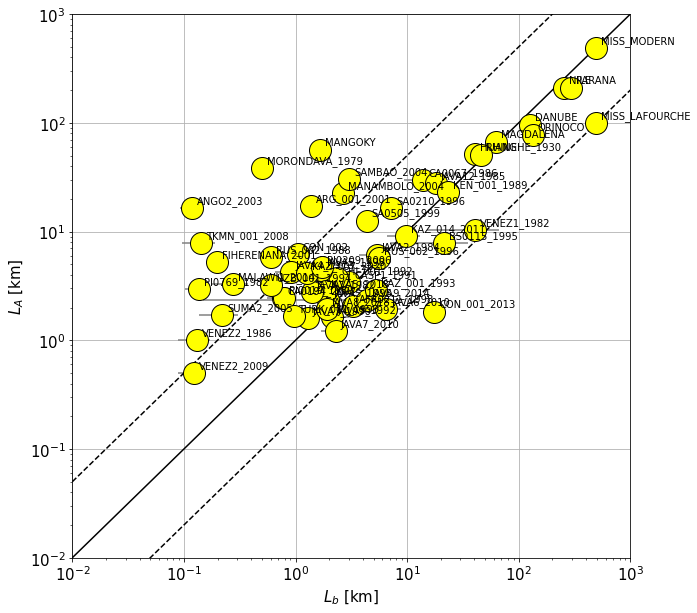

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped['L_b [km]']['nanmedian'], df_grouped['L_A [km]']['nanmedian'], xerr=df_grouped['L_b [km]']['IQR']/2, yerr=df_grouped['L_A [km]']['IQR']/2, 
            fmt='o', ms=22, markerfacecolor='yellow', ecolor='grey', markeredgecolor='black')

plt.grid('on')
ax.set_xlabel('$L_b$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.01, top=1000)
ax.set_xlim(left=.01, right=1000)

for idx, row in df_grouped.iterrows():
    ax.annotate(idx, xy=(row['L_b [km]']['nanmedian'],
                         row['L_A [km]']['nanmedian']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points',
               fontsize=10)
    
plt.show()

NameError: name 'df_grouped' is not defined

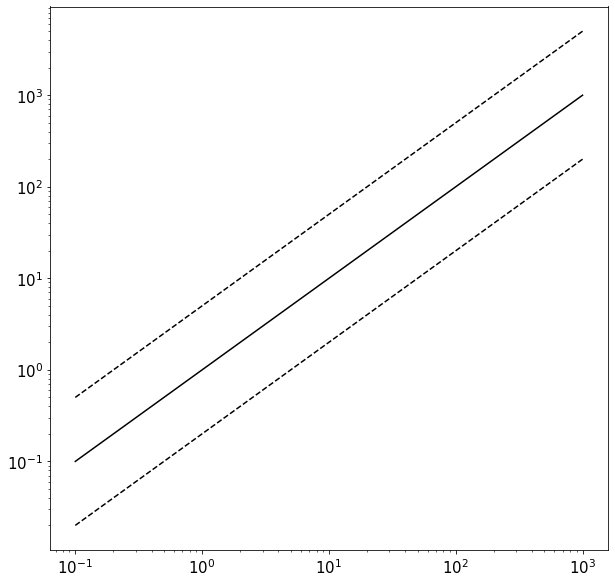

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped['l_scour [km]']['nanmedian'], df_grouped['L_A [km]']['nanmedian'], xerr=df_grouped['l_scour [km]']['IQR']/2, yerr=df_grouped['L_A [km]']['IQR']/2, 
            fmt='o', ms=22, markerfacecolor='green', ecolor='black', markeredgecolor='black', alpha=0.5)
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.01, top=1000)
ax.set_xlim(left=.01, right=1000)
# for idx, row in df_grouped.iterrows():
#     ax.annotate(idx, xy=(row['l_scour [km]']['nanmedian'],
#                          row['L_A [km]']['nanmedian']), 
#                 xytext=(5, 5), xycoords='data', textcoords='offset points',
#                fontsize=10)
    
plt.show()

In [8]:

Av_ID = []
lb_mean = []
tadj_mean = []
lscour_mean = []
lb_std = []
tadj_std = []
lscour_std = []

for idx, r in df_grouped.iterrows():
    Av_ID.append(idx)
    lb_mean.append(r['L_b [km]']['mean'])
    lscour_mean.append(r['l_scour [km]']['mean'])
    tadj_mean.append(r['L_b [km]']['mean'])
    lb_std.append(r['L_b [km]']['std'])
    lscour_std.append(r['l_scour [km]']['std'])
    tadj_std.append(r['L_b [km]']['std'])
    
mean_value_df = pd.DataFrame({'Av_ID':Av_ID, 'L_scour [km]':lscour_mean, 
                              'L_scour_std_dev [km]':lscour_std,
                             'L_b [km]':lb_mean, 
                              'L_b_std_dev [km]':lb_std,
                             'T_adj':tadj_mean, 
                              'T_adj_std_dev [km]':tadj_std})

mean_value_df = mean_value_df.set_index('Av_ID')
global_avulsions_pop = global_avulsions.merge(mean_value_df, on='Av_ID')


In [9]:
global_avulsions_pop

Av_ID                            River    Year        From  \
0      AFR0211_1998                        Catumbela  1998.0       study   
1        ANGO2_2003                         Coporolo  2003.0       study   
2       BS0115_1995                             Kura  1995.0       study   
3       CA0067_1986                          Motagua  1986.0       study   
4       CA0194_2007                           Samala  2007.0       study   
5        CASP1_1991                        Sefid Rud  1991.0       study   
6       JAVA12_1985                    Bengawan Solo  1985.0       study   
7        JAVA2_1984                           Serang  1984.0       study   
8        JAVA3_1992                            Bodri  1992.0       study   
9        JAVA4_1973                            Comal  1973.0       study   
10       JAVA5_1995                         Kelampis  1995.0       study   
11       JAVA5_1998                         Kelampis  1998.0       study   
12       JAVA5_2018                         Kelampis  2018.0       study   
13       JAVA6_2010                  Cirambatan Baru  2010.0       study   
14       JAVA7_1982                        Cikandung  1982.0       study   
15       JAVA7_1990                        Cikandung  1990.0       study   
16       JAVA7_2010                        Cikandung  2010.0       study   
17       JAVA8_2018                         Kali Cbl  2018.0       study   
18       JAVA9_2014                         Cisadane  2014.0       study   
19     MALAWI1_2014                         Lilongwe  2014.0       study   
20      PI0019_1989                     Batu Gerigis  1989.0       study   
21      PI0209_2006                           Pemali  2006.0       study   
22      PI0769_1982                             Agos  1982.0       study   
23      SA0210_1996                           Mitare  1996.0       study   
24      SA0505_1999                           Tumbes  1999.0       study   
25       SUMA2_2005                        Peusangan  2005.0       study   
26      VENEZ1_1982                        Catatumbo  1982.0       study   
27      VENEZ2_1986                            Misoa  1986.0       study   
28      VENEZ2_2009                            Misoa  2009.0       study   
29     ARG_001_2001                             Sali  2001.0       study   
30     TAN_002_2011                        Ndasegera  2011.0       study   
31          CON_002                              NaN     0.0       study   
32     CON_001_2013                              NaN  2013.0       study   
33     KEN_001_1989                              NaN  1989.0       study   
34     CHI_001_1992                              NaN  1992.0       study   
35     KAZ_001_1993                              NaN  1993.0       study   
36     KAZ_007_2020                              NaN  2020.0       study   
37     KAZ_014_2011                              NaN  2011.0       study   
38     RUS_002_1988                              NaN  1988.0       study   
39     RUS_002_1996                              NaN  1996.0       study   
40     UZB_001_1994                              NaN  1994.0       study   
41    TKMN_001_2008                              NaN  2008.0       study   
42    TURK_001_1993                              NaN  1993.0       study   
43             NILE                             Nile     NaN      global   
44        MAGDALENA                        Magdalena     NaN      global   
45          ORINOCO                          Orinoco     NaN      global   
46            RHINE                      Rhine-Meuse     NaN      global   
47           DANUBE                           Danube     NaN      global   
48           PARANA                           Paraná     NaN      global   
49      MISS_MODERN  Mississippi, Modern-Atchafalaya     NaN      global   
50   MISS_LAFOURCHE    Mississippi, Lafourche-Modern     NaN      global   
51     HUANGHE_1930                          Huanghe     NaN  

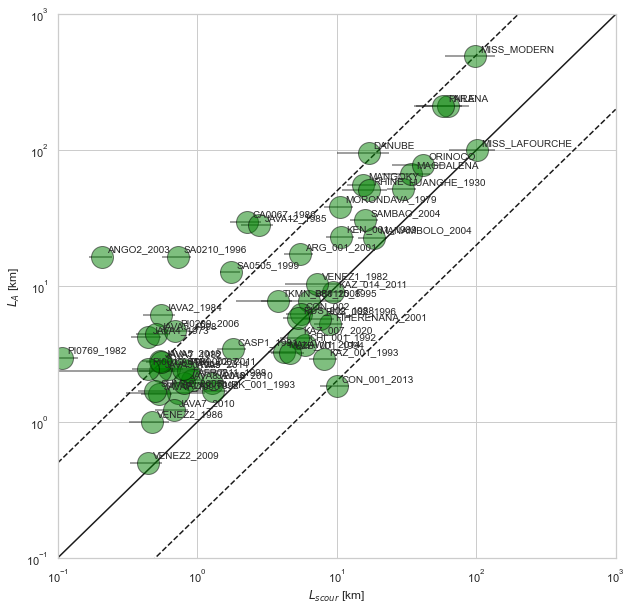

In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped['l_scour [km]']['mean'], df_grouped['L_A [km]']['mean'], xerr=df_grouped['l_scour [km]']['std'], yerr=df_grouped['L_A [km]']['std'], 
            fmt='o', ms=22, markerfacecolor='green', ecolor='black', markeredgecolor='black', alpha=0.5)
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)

for idx, row in df_grouped.iterrows():
    ax.annotate(idx, xy=(row['l_scour [km]']['mean'],
                         row['L_A [km]']['mean']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points',
               fontsize=10)
    
plt.show()

In [11]:
global_avulsions

Av_ID                            River    Year        From  \
0      AFR0211_1998                        Catumbela  1998.0       study   
1        ANGO2_2003                         Coporolo  2003.0       study   
2       BS0115_1995                             Kura  1995.0       study   
3       CA0067_1986                          Motagua  1986.0       study   
4       CA0194_2007                           Samala  2007.0       study   
5        CASP1_1991                        Sefid Rud  1991.0       study   
6       JAVA12_1985                    Bengawan Solo  1985.0       study   
7        JAVA2_1984                           Serang  1984.0       study   
8        JAVA3_1992                            Bodri  1992.0       study   
9        JAVA4_1973                            Comal  1973.0       study   
10       JAVA5_1995                         Kelampis  1995.0       study   
11       JAVA5_1998                         Kelampis  1998.0       study   
12       JAVA5_2018                         Kelampis  2018.0       study   
13       JAVA6_2010                  Cirambatan Baru  2010.0       study   
14       JAVA7_1982                        Cikandung  1982.0       study   
15       JAVA7_1990                        Cikandung  1990.0       study   
16       JAVA7_2010                        Cikandung  2010.0       study   
17       JAVA8_2018                         Kali Cbl  2018.0       study   
18       JAVA9_2014                         Cisadane  2014.0       study   
19     MALAWI1_2014                         Lilongwe  2014.0       study   
20      PI0019_1989                     Batu Gerigis  1989.0       study   
21      PI0209_2006                           Pemali  2006.0       study   
22      PI0769_1982                             Agos  1982.0       study   
23      SA0210_1996                           Mitare  1996.0       study   
24      SA0505_1999                           Tumbes  1999.0       study   
25       SUMA2_2005                        Peusangan  2005.0       study   
26      VENEZ1_1982                        Catatumbo  1982.0       study   
27      VENEZ2_1986                            Misoa  1986.0       study   
28      VENEZ2_2009                            Misoa  2009.0       study   
29     ARG_001_2001                             Sali  2001.0       study   
30     TAN_002_2011                        Ndasegera  2011.0       study   
31          CON_002                              NaN     0.0       study   
32     CON_001_2013                              NaN  2013.0       study   
33     KEN_001_1989                              NaN  1989.0       study   
34     CHI_001_1992                              NaN  1992.0       study   
35     KAZ_001_1993                              NaN  1993.0       study   
36     KAZ_007_2020                              NaN  2020.0       study   
37     KAZ_014_2011                              NaN  2011.0       study   
38     RUS_002_1988                              NaN  1988.0       study   
39     RUS_002_1996                              NaN  1996.0       study   
40     UZB_001_1994                              NaN  1994.0       study   
41    TKMN_001_2008                              NaN  2008.0       study   
42    TURK_001_1993                              NaN  1993.0       study   
62             NILE                             Nile     NaN      global   
63        MAGDALENA                        Magdalena     NaN      global   
64          ORINOCO                          Orinoco     NaN      global   
65            RHINE                      Rhine-Meuse     NaN      global   
66           DANUBE                           Danube     NaN      global   
67           PARANA                           Paraná     NaN      global   
68      MISS_MODERN  Mississippi, Modern-Atchafalaya     NaN      global   
69   MISS_LAFOURCHE    Mississippi, Lafourche-Modern     NaN      global   
70     HUANGHE_1930                          Huanghe     NaN  

<ipython-input-12-1ff402332612>:4: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-12-1ff402332612>:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


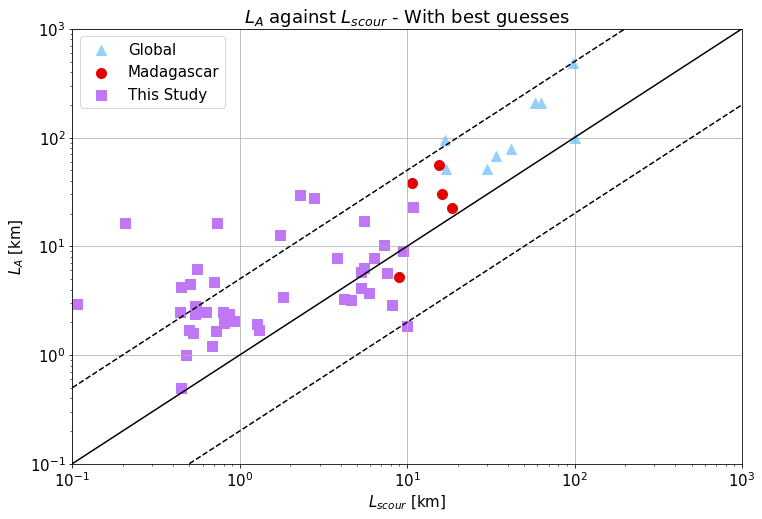

In [12]:
# LA vs Lscour

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_global = global_avulsions_pop['L_A [km]'][global_avulsions_pop['From'] == 'global']
Lscour_global = global_avulsions_pop['L_scour [km]_y'][global_avulsions_pop['From'] == 'global']

LA_mads = global_avulsions_pop['L_A [km]'][global_avulsions_pop['From'] == 'madagascar']
Lscour_mads = global_avulsions_pop['L_scour [km]_y'][global_avulsions_pop['From'] == 'madagascar']

LA_study = global_avulsions_pop['L_A [km]'][global_avulsions_pop['From'] == 'study']
Lscour_study = global_avulsions_pop['L_scour [km]_y'][global_avulsions_pop['From'] == 'study']

h1 = ax.scatter(Lscour_global, LA_global, s=100, marker='^', c='xkcd:light blue') 
h2 = ax.scatter(Lscour_mads, LA_mads, s=100, marker='o', c='xkcd:red') 
h3 = ax.scatter(Lscour_study, LA_study, s=100, marker='s', c='xkcd:light purple') 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.legend([h1, h2, h3], ['Global', 'Madagascar', 'This Study'])
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
plt.title('$L_A$ against $L_{scour}$ - With best guesses')

fig.savefig('./figures/LA_vs_Lscour.pdf')

In [13]:
gt_2_times_LB = df_grouped.loc[df_grouped['L_A [km]']['mean']>df_grouped['L_b [km]']['mean']*2]

In [14]:
lt_2_times_LB = df_grouped.loc[df_grouped['L_A [km]']['mean']<(df_grouped['L_b [km]']['mean']*2)]

<ipython-input-15-239218861333>:4: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')


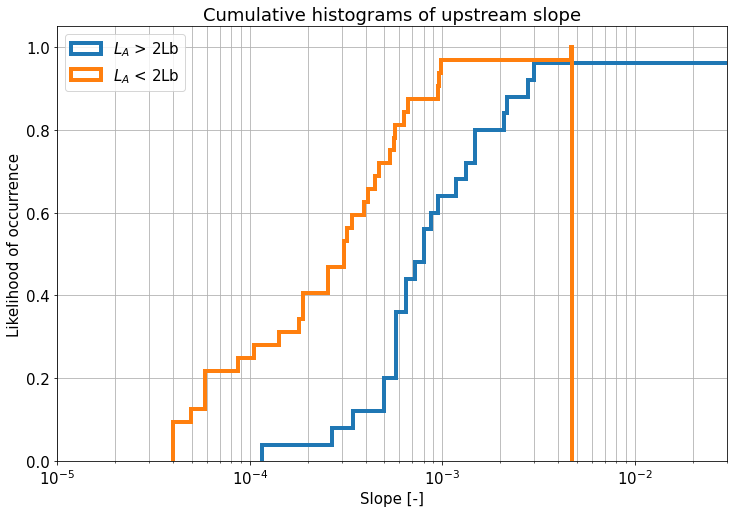

In [15]:
bins = 500

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')

ax.hist(gt_2_times_LB['S [-]']['mean'], bins, label='$L_A$ > 2Lb', cumulative=True, density=True, histtype='step', linewidth=4)
ax.hist(lt_2_times_LB['S [-]']['mean'], bins, label='$L_A$ < 2Lb', cumulative=True, density=True, histtype='step', linewidth=4)
ax.legend(loc='upper right')
ax.legend(loc='upper left')
ax.set_title('Cumulative histograms of upstream slope')
ax.set_xlabel('Slope [-]')
ax.set_ylabel('Likelihood of occurrence')
ax.set_xlim([0.00001,0.03])
ax.grid(True)
plt.grid(True, which="both")
plt.show()


<ipython-input-16-a619e16e45d1>:14: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[0].set_xscale("log", nonposx='clip')
<ipython-input-16-a619e16e45d1>:15: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[0].set_yscale("log", nonposy='clip')
<ipython-input-16-a619e16e45d1>:39: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[1].set_xscale("log", nonposx='clip')
<ipython-input-16-a619e16e45d1>:40: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two 

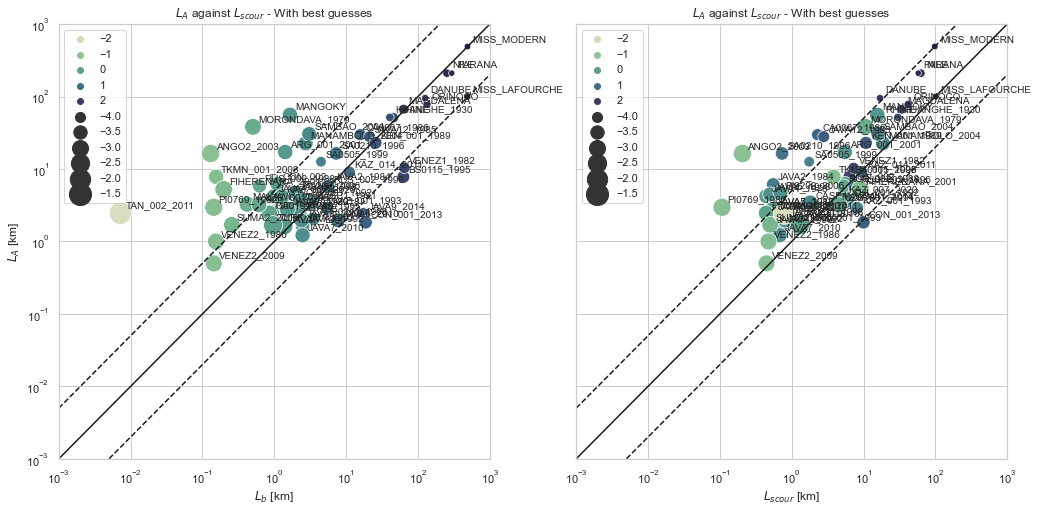

In [16]:

global_avulsions_pop_plot = global_avulsions_pop.copy()

global_avulsions_pop_plot['S_size'] = np.log10(global_avulsions_pop_plot['S [-]'])
global_avulsions_pop_plot['t_adj_size'] = np.log10(global_avulsions_pop_plot['T_adj'])

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
fig, ax = plt.subplots(figsize=(17, 8), nrows=1, ncols=2, sharey=True)

ax[0].set_xscale("log", nonposx='clip')
ax[0].set_yscale("log", nonposy='clip')

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.scatterplot(
    y="L_A [km]", x="L_b [km]_y",
    hue=global_avulsions_pop_plot['t_adj_size'].values, 
    size=global_avulsions_pop_plot['S_size'].values,
    palette=cmap, sizes=(40, 500),
    data=global_avulsions_pop_plot,
    ax=ax[0]
)

refplot = np.linspace(.001,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax[0].plot(refplot,refplot, color='k')
ax[0].plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax[0].plot(refplot, refplot_lower, color='k', linestyle='dashed')
ax[0].set_xlabel('$L_{b}$ [km]')
ax[0].set_ylabel('$L_A$ [km]')
ax[0].set_ylim(bottom=.001, top=1000)
ax[0].set_xlim(left=.001, right=1000)
ax[0].set_title('$L_A$ against $L_{scour}$ - With best guesses')

ax[1].set_xscale("log", nonposx='clip')
ax[1].set_yscale("log", nonposy='clip')

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.scatterplot(
    y="L_A [km]", x="L_scour [km]_y",
    hue=global_avulsions_pop_plot['t_adj_size'].values, 
    size=global_avulsions_pop_plot['S_size'].values,
    palette=cmap, sizes=(40, 500),
    data=global_avulsions_pop_plot,
    ax=ax[1]
)

refplot = np.linspace(.001,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax[1].plot(refplot,refplot, color='k')
ax[1].plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax[1].plot(refplot, refplot_lower, color='k', linestyle='dashed')
ax[1].set_xlabel('$L_{scour}$ [km]')
ax[1].set_ylabel('$L_A$ [km]')
ax[1].set_ylim(bottom=.001, top=1000)
ax[1].set_xlim(left=.001, right=1000)
ax[1].set_title('$L_A$ against $L_{scour}$ - With best guesses')

for idx, row in global_avulsions_pop_plot.iterrows():
    ax[1].annotate(row['Av_ID'], xy=(row['L_scour [km]_y'],
                         row['L_A [km]']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points',
               fontsize=10)
    
for idx, row in global_avulsions_pop_plot.iterrows():
    ax[0].annotate(row['Av_ID'], xy=(row['L_b [km]_y'],
                         row['L_A [km]']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points',
               fontsize=10)   
plt.show()

<ipython-input-17-ad53ee27522d>:14: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[0].set_xscale("log", nonposx='clip')
<ipython-input-17-ad53ee27522d>:15: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[0].set_yscale("log", nonposy='clip')
<ipython-input-17-ad53ee27522d>:39: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[1].set_xscale("log", nonposx='clip')
<ipython-input-17-ad53ee27522d>:40: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two 

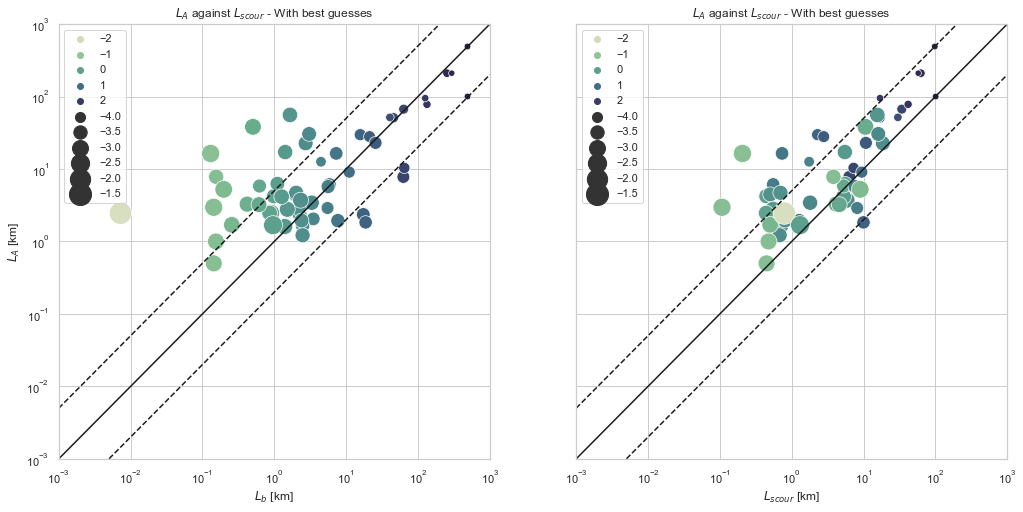

In [17]:

global_avulsions_pop_plot = global_avulsions_pop.copy()

global_avulsions_pop_plot['S_size'] = np.log10(global_avulsions_pop_plot['S [-]'])
global_avulsions_pop_plot['t_adj_size'] = np.log10(global_avulsions_pop_plot['T_adj'])

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
fig, ax = plt.subplots(figsize=(17, 8), nrows=1, ncols=2, sharey=True)

ax[0].set_xscale("log", nonposx='clip')
ax[0].set_yscale("log", nonposy='clip')

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.scatterplot(
    y="L_A [km]", x="L_b [km]_y",
    hue=global_avulsions_pop_plot['t_adj_size'].values, 
    size=global_avulsions_pop_plot['S_size'].values,
    palette=cmap, sizes=(40, 500),
    data=global_avulsions_pop_plot,
    ax=ax[0]
)

refplot = np.linspace(.001,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax[0].plot(refplot,refplot, color='k')
ax[0].plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax[0].plot(refplot, refplot_lower, color='k', linestyle='dashed')
ax[0].set_xlabel('$L_{b}$ [km]')
ax[0].set_ylabel('$L_A$ [km]')
ax[0].set_ylim(bottom=.001, top=1000)
ax[0].set_xlim(left=.001, right=1000)
ax[0].set_title('$L_A$ against $L_{scour}$ - With best guesses')

ax[1].set_xscale("log", nonposx='clip')
ax[1].set_yscale("log", nonposy='clip')

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.scatterplot(
    y="L_A [km]", x="L_scour [km]_y",
    hue=global_avulsions_pop_plot['t_adj_size'].values, 
    size=global_avulsions_pop_plot['S_size'].values,
    palette=cmap, sizes=(40, 500),
    data=global_avulsions_pop_plot,
    ax=ax[1]
)

refplot = np.linspace(.001,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax[1].plot(refplot,refplot, color='k')
ax[1].plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax[1].plot(refplot, refplot_lower, color='k', linestyle='dashed')
ax[1].set_xlabel('$L_{scour}$ [km]')
ax[1].set_ylabel('$L_A$ [km]')
ax[1].set_ylim(bottom=.001, top=1000)
ax[1].set_xlim(left=.001, right=1000)
ax[1].set_title('$L_A$ against $L_{scour}$ - With best guesses')

plt.show()